<a href="https://colab.research.google.com/github/RiddhimanRaut/Deep-Learning-based-CPR-estimation/blob/main/CPR_prediction_multivariate_LSTM_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
#Standard Imports for RNNs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime

In [67]:
url = "https://github.com/RiddhimanRaut/Deep-Learning-based-CPR-estimation/blob/main/excel_dataset.xlsx?raw=true"
df = pd.read_excel(url)
#df = df[5::6] #Hour-wise Data
df.head()

,Date Time,CPRAVG,PROP,BUT,ETHYLENE,AI12201M,FLW,COT,TEMP,PRESS,O2,DRAFT,ETH
0,01.01.2009 00:10:00,0.428151,18.960609,3.973630,29.732470,0.014431,30711.65039,820.118210,632.399261,0.466357,1.444160,-5.616851,75.809700
1,01.01.2009 00:20:00,0.427783,18.960360,3.973562,30.123590,0.014822,30700.66016,819.662811,633.057602,0.475288,1.413894,-5.540349,75.810066
2,01.01.2009 00:30:00,0.427432,19.009649,4.181924,30.477831,0.012689,30689.66016,819.886444,631.841385,0.464559,1.515123,-5.628389,75.552841
3,01.01.2009 00:40:00,0.427082,19.155710,3.950392,30.425819,0.012580,30678.66016,819.660172,632.495224,0.471809,1.404055,-5.576591,75.580223
4,01.01.2009 00:50:00,0.426732,19.334640,3.689848,30.546061,0.012472,30667.66016,819.646805,632.388214,0.470504,1.191485,-5.274679,75.638023


In [68]:
#Separating Date and Time
#To be used in plotting in X-axis
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S') #pop command takes the Date Time Column out of df, so df no longer has that column.

We need to remove $Ethylene$ and $AI12201M$ columns as they are not controllable factors. 

In [69]:
df = df.drop('ETHYLENE',axis=1)
df = df.drop('AI12201M',axis=1)
df.head()

,CPRAVG,PROP,BUT,FLW,COT,TEMP,PRESS,O2,DRAFT,ETH
0,0.428151,18.960609,3.973630,30711.65039,820.118210,632.399261,0.466357,1.444160,-5.616851,75.809700
1,0.427783,18.960360,3.973562,30700.66016,819.662811,633.057602,0.475288,1.413894,-5.540349,75.810066
2,0.427432,19.009649,4.181924,30689.66016,819.886444,631.841385,0.464559,1.515123,-5.628389,75.552841
3,0.427082,19.155710,3.950392,30678.66016,819.660172,632.495224,0.471809,1.404055,-5.576591,75.580223
4,0.426732,19.334640,3.689848,30667.66016,819.646805,632.388214,0.470504,1.191485,-5.274679,75.638023


In [70]:
#Variables for training
cols = list(df)[0:df.shape[1]]
#To enforce that values in these columns are actually float type data
df_for_rnn = df[cols].astype(float)

In [71]:
#Creating training_df and test_df
n = len(df)
training_df = df_for_rnn[0:int(n*0.7)]
test_set = df_for_rnn[int(n*0.7):n]

In [72]:
#Scaling the Dataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#scaler = StandardScaler()
scaler = MinMaxScaler(feature_range = (0,1))
df_for_training_scaled = scaler.fit_transform(training_df) #Scales and converts to numpy object
print('Scaled Dataset:\n',df_for_training_scaled)

Scaled Dataset:
 [[0.04261512 0.39141737 0.71843606 ... 0.54553167 0.061713   0.69995722]
 [0.03834461 0.39139343 0.71841953 ... 0.53416085 0.09054363 0.69998058]
 [0.03428528 0.39611563 0.76908826 ... 0.57219227 0.05736476 0.68357295]
 ...
 [0.94817084 0.28810413 0.68416253 ... 0.67555781 0.51802072 0.79587724]
 [0.95048011 0.28807252 0.68538325 ... 0.68702255 0.51584291 0.79587529]
 [0.95188739 0.28809554 0.70426883 ... 0.68955967 0.51498322 0.79587237]]


In [73]:
#Readying the Multivariate Input and Univariate Output

#initialisation
trainX = [] 
trainY = []

n_future = 1 #number of hours into the future
n_past = 60  #number of hours into the past

for i in range(n_past, len(df_for_training_scaled)-n_future+1):
  trainX.append(df_for_training_scaled[i-60:i,:])
  trainY.append(df_for_training_scaled[i+n_future-1:i+n_future,0])
trainX = np.array(trainX)   # shape 1: no of records, shape 2: past_days, shape 3: input_cols
trainY = np.array(trainY)   # shape 1: records, shape 2: future prediction data
print('TrainX shape = (%d,%d,%d)'%(trainX.shape[0],trainX.shape[1],trainX.shape[2]))
print('TrainY shape = (%d,%d)'%(trainY.shape[0],trainY.shape[1]))

TrainX shape = (8667,60,10)
TrainY shape = (8667,1)


In [74]:
# Part 2 - Building the RNN

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

model = Sequential()
model.add(LSTM(64,activation='sigmoid',return_sequences=True,input_shape = (trainX.shape[1],trainX.shape[2])))
model.add(LSTM(32,activation='sigmoid',return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam',loss = 'mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 60, 64)            19200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 31,649
Trainable params: 31,649
Non-trainable params: 0
_________________________________________________________________


In [75]:
#Let's traaaaaaaaaaaainnn

history = model.fit(trainX,trainY,epochs=100,verbose=1,batch_size=32,validation_split=0.1)

Epoch 1/100
244/244 [==============================] - 18s 56ms/step - loss: 0.2311 - val_loss: 0.0264
Epoch 2/100
244/244 [==============================] - 13s 53ms/step - loss: 0.0496 - val_loss: 0.0212
Epoch 3/100
244/244 [==============================] - 13s 53ms/step - loss: 0.0182 - val_loss: 0.0111
Epoch 4/100
244/244 [==============================] - 13s 53ms/step - loss: 0.0136 - val_loss: 0.0162
Epoch 5/100
244/244 [==============================] - 13s 52ms/step - loss: 0.0121 - val_loss: 0.0093
Epoch 6/100
244/244 [==============================] - 13s 53ms/step - loss: 0.0106 - val_loss: 0.0128
Epoch 7/100
244/244 [==============================] - 13s 53ms/step - loss: 0.0087 - val_loss: 0.0023
Epoch 8/100
244/244 [==============================] - 13s 52ms/step - loss: 0.0080 - val_loss: 0.0058
Epoch 9/100
244/244 [==============================] - 13s 53ms/step - loss: 0.0068 - val_loss: 0.0035
Epoch 10/100
244/244 [==============================] - 13s 53ms/step - l

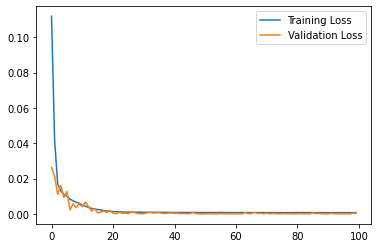

In [76]:
plt.plot(history.history['loss'],label = 'Training Loss')
plt.plot(history.history['val_loss'],label = 'Validation Loss')
plt.legend()

In [77]:
test_df_scaled = scaler.transform(test_set)
testX = []
for i in range(n_past,len(test_df_scaled)+n_future-1):
  testX.append(test_df_scaled[i-n_past:i,:])
testX = np.array(testX)
testX.shape

(3681, 60, 10)

[[0.50640863]
 [0.5063041 ]
 [0.50623083]
 ...
 [0.51436013]
 [0.51432025]
 [0.51416326]]


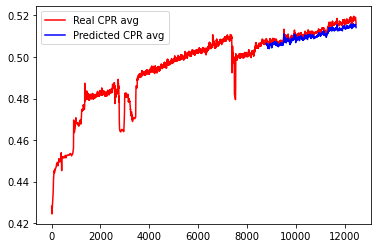

In [78]:
predicted_CPRAVG = model.predict(testX)
predicted_CPRAVG = np.repeat(predicted_CPRAVG,test_df_scaled.shape[1],axis = -1)
predicted_CPRAVG = scaler.inverse_transform(predicted_CPRAVG)[:,0]
predicted_CPRAVG = predicted_CPRAVG.reshape(-1,1)
print(predicted_CPRAVG)
predicted_CPRAVGplot = np.empty_like(df)
predicted_CPRAVGplot[:,:] = np.nan
predicted_CPRAVGplot[training_df.shape[0]+n_past:df.shape[0],:] = predicted_CPRAVG
plt.plot(df['CPRAVG'],color = 'red', label = 'Real CPR avg')
plt.plot(predicted_CPRAVGplot[:,0], color = 'blue', label = 'Predicted CPR avg')
plt.legend()

Time to predict the future!

We shall use the previous $200$ data predict $CPRAVG$.


In [97]:
starting_record = df.shape[0]
CPRAVG_real_values = df['CPRAVG']
temp = pd.DataFrame.to_numpy(df)
url_future = "https://raw.githubusercontent.com/RiddhimanRaut/Deep-Learning-based-CPR-estimation/main/Future_test_dataset.csv"
df_future = pd.read_csv(url_future)
length_of_future_prediction = df_future.shape[0]
for i in range (length_of_future_prediction):
  print("Predicting CPRAVG for entry:",i)
  #Gathering the past 200 data
  total_df_length = temp.shape[0]
  future_Xinput = temp[total_df_length - 200:total_df_length]
  future_Xinput_scaled = scaler.transform(future_Xinput)
  future_Xinput_scaled_batch = np.array([future_Xinput_scaled])
  future_prediction = model.predict(future_Xinput_scaled_batch)
  future_prediction = np.repeat(future_prediction, future_Xinput_scaled.shape[1],axis = -1)
  future_prediction = scaler.inverse_transform(future_prediction)[:,0]
  #Parameters to be set:
  future_data = df_future.loc[i]
  future_data = pd.DataFrame.to_numpy(future_data)
  future_data = future_data[0:10]
  future_data[0] = future_prediction[0]
  # print(future_data)
  future_data = future_data.reshape(1,10)
  temp = np.append(temp,future_data, axis = 0)

future_dataset_numpy = temp[starting_record:temp.shape[0],:]
CPRAVG_predicted_values = future_dataset_numpy[:,0]

Streaming output truncated to the last 5000 lines.
Predicting CPRAVG for entry: 605
Predicting CPRAVG for entry: 606
Predicting CPRAVG for entry: 607
Predicting CPRAVG for entry: 608
Predicting CPRAVG for entry: 609
Predicting CPRAVG for entry: 610
Predicting CPRAVG for entry: 611
Predicting CPRAVG for entry: 612
Predicting CPRAVG for entry: 613
Predicting CPRAVG for entry: 614
Predicting CPRAVG for entry: 615
Predicting CPRAVG for entry: 616
Predicting CPRAVG for entry: 617
Predicting CPRAVG for entry: 618
Predicting CPRAVG for entry: 619
Predicting CPRAVG for entry: 620
Predicting CPRAVG for entry: 621
Predicting CPRAVG for entry: 622
Predicting CPRAVG for entry: 623
Predicting CPRAVG for entry: 624
Predicting CPRAVG for entry: 625
Predicting CPRAVG for entry: 626
Predicting CPRAVG for entry: 627
Predicting CPRAVG for entry: 628
Predicting CPRAVG for entry: 629
Predicting CPRAVG for entry: 630
Predicting CPRAVG for entry: 631
Predicting CPRAVG for entry: 632
Predicting CPRAVG for ent

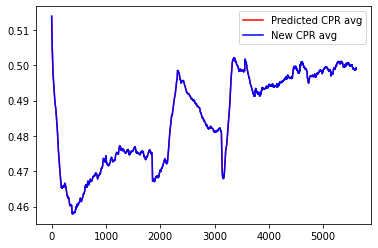

In [98]:
plt.plot(CPRAVG_predicted_values,color = 'red', label = 'Predicted CPR avg')
new_CPRAVG = df_future['CPRAVG']
plt.plot(new_CPRAVG,color = 'Blue', label = 'New CPR avg')
plt.legend()